## Audio data sample

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = "/content/drive/MyDrive/Colab Notebooks/AI-2024/Data/genres_original/blues/blues.00000.wav"

Text(0.5, 1.0, 'Waveform')

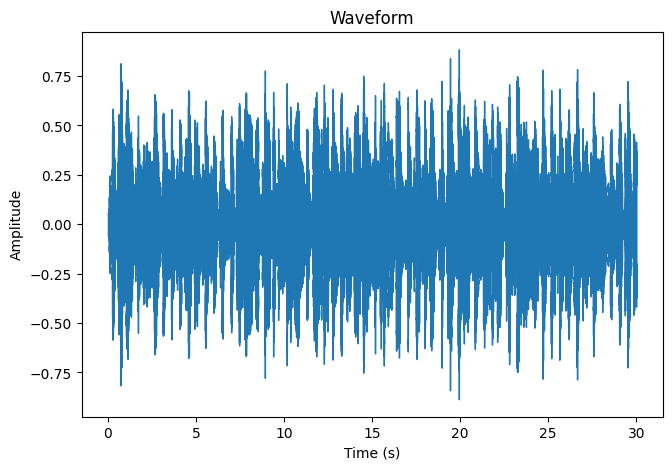

In [ ]:
FIG_SIZE = (7.5,5)


# load audio file usig Librosa
signal, sample_rate = librosa.load(file, sr=22050)

# Show waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power spectrum')

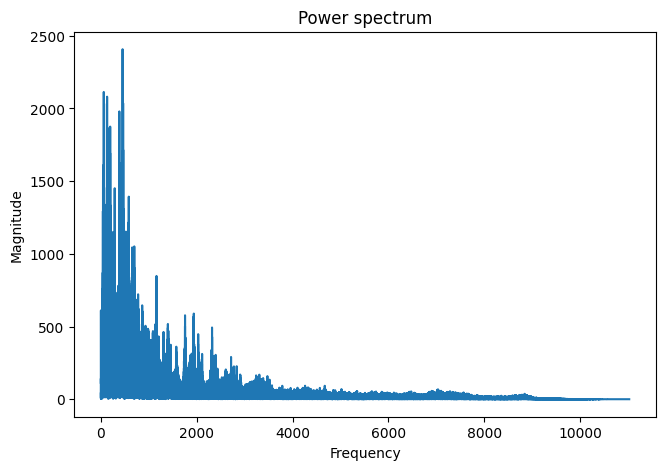

In [ ]:
# Fourier transform
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_magnitude = magnitude[:int(len(magnitude)/2)]
left_frequency = frequency[:int(len(frequency)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

Text(0.5, 1.0, 'Spectrogram')

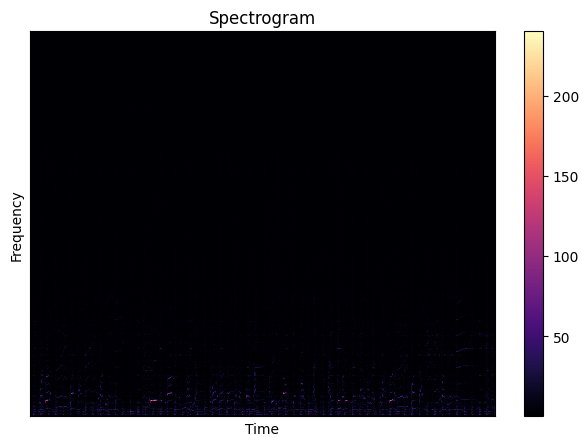

In [ ]:
# STFT Spectrogram
n_fft = 2048
hop_length = 512

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

Text(0.5, 1.0, 'Spectrogram (dB)')

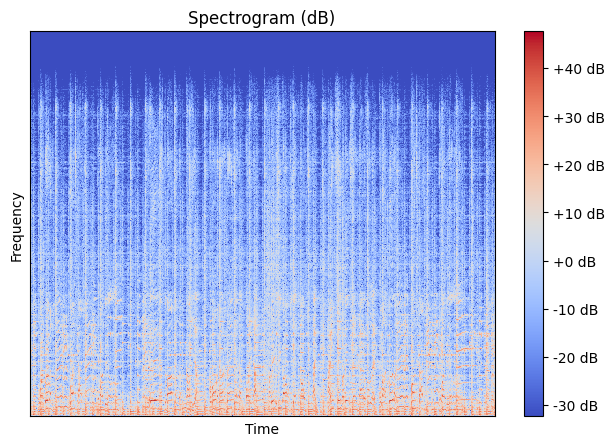

In [ ]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'MFCCs')

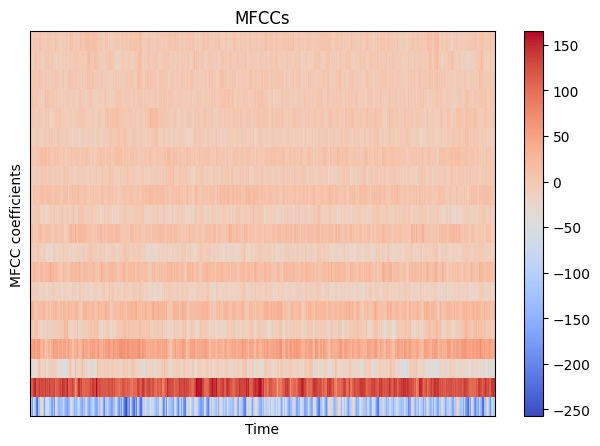

In [ ]:
# MFCCs

MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

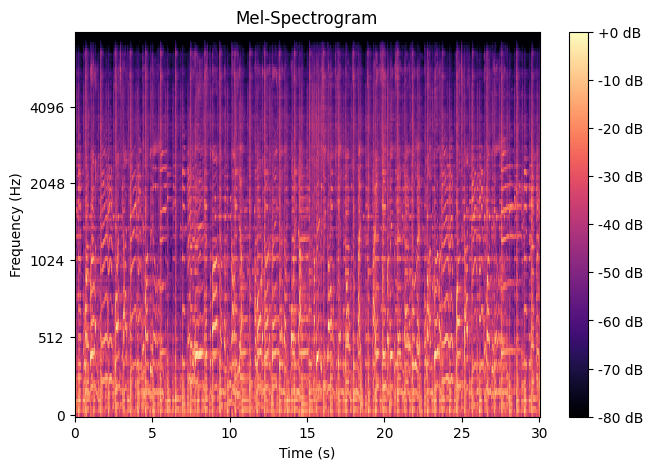

In [ ]:
# Generate the Mel-Spectrogram
S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
S_dB = librosa.power_to_db(S, ref=np.max)

# Display the Mel-Spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(S_dB, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Mel-Spectrogram")
plt.show()

(-0.5, 1292.5, -0.5, 127.5)

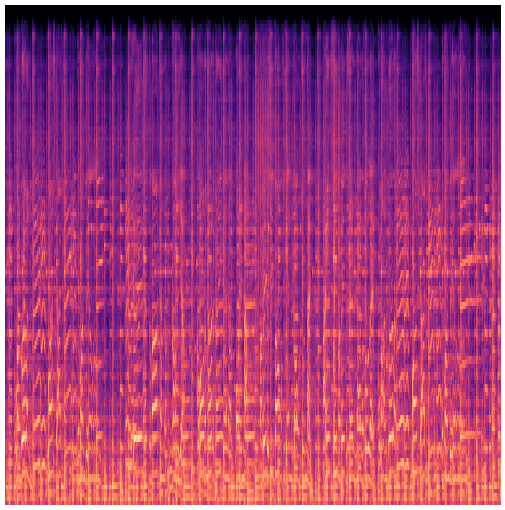

In [ ]:
plt.figure(figsize=(12.8, 13), dpi=50)  # Adjust figsize and dpi to maintain quality
librosa.display.specshow(S_dB, sr=sample_rate, hop_length=hop_length, x_axis=None, y_axis=None)
plt.axis('off')

## Music genre classification: Preparing the dataset

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Constants for the dataset and image paths
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-2024/Data/genres_original"
IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-2024/Data/mel_spectrogram_images"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # Duration of each audio track in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mel_spectrograms_as_images(dataset_path, image_path, n_mels=128, n_fft=2048, hop_length=512, num_segments=10, f_max=None):
    # Calculate the number of samples per segment
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)

    # Walk through the dataset directory structure
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        # Skip the root directory
        if dirpath != dataset_path:
            # Extract the genre label from the directory name
            genre_label = os.path.basename(dirpath)
            # Create a subdirectory for the genre in the image path if it doesn't exist
            genre_dir = os.path.join(image_path, genre_label)
            if not os.path.exists(genre_dir):
                os.makedirs(genre_dir)

            print("\nProcessing: {}".format(genre_label))

            # Collect existing segment filenames to avoid redundant checks
            existing_files = set(os.listdir(genre_dir))

            # Process each audio file in the genre directory
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # Load the audio file partially segment by segment
                for d in range(num_segments):
                    segment_filename = f"{os.path.splitext(f)[0]}_segment{d}.png"
                    segment_filepath = os.path.join(genre_dir, segment_filename)

                    # Skip if the segment image already exists
                    if segment_filename in existing_files:
                        continue

                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # Compute the Mel-Spectrogram for the segment
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, offset=start/SAMPLE_RATE, duration=samples_per_segment/SAMPLE_RATE)
                    mel_spectrogram = librosa.feature.melspectrogram(
                        y=signal,
                        sr=sample_rate,
                        n_mels=n_mels,
                        n_fft=n_fft,
                        hop_length=hop_length,
                        fmax=f_max
                    )
                    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                    # Plot and save the Mel-Spectrogram as an image without text or numbers
                    plt.figure(figsize=(12.8, 13), dpi=50)  # Adjust figsize and dpi to maintain quality
                    librosa.display.specshow(mel_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis=None, y_axis=None)
                    plt.axis('off')  # Turn off the axis
                    plt.savefig(segment_filepath, bbox_inches='tight', pad_inches=0)
                    plt.close()

# Run the function to save Mel-Spectrogram images
save_mel_spectrograms_as_images(DATASET_PATH, IMAGE_PATH, num_segments=10, f_max=11025)
print("\nDone!")



Processing: reggae

Processing: metal

Processing: rock

Processing: blues

Processing: country

Processing: jazz

Processing: pop

Processing: disco

Processing: classical

Processing: hiphop

Done!


## Music genre classification: Implementing CNN

Import Libraries and Define Constants

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Constants for paths
IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-2024/Data/mel_spectrogram_images"
IMG_HEIGHT = 128
IMG_WIDTH = 130
BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.2


Create Data Generators

width_shift_range=0.1,  # Horizontal shift
height_shift_range=0.1,  # Vertical shift
brightness_range=[0.8, 1.2],  # Change brightness
zoom_range=0.1  # Zoom in/out

In [ ]:
def create_data_generators(image_path, img_height, img_width, batch_size, validation_split=0.2):
    # Create an ImageDataGenerator for training with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=validation_split,
        width_shift_range=0.1,  # Horizontal shift
        height_shift_range=0.1,  # Vertical shift
        brightness_range=[0.8, 1.2]  # Change brightness
    )


    # Create training data generator
    train_generator = train_datagen.flow_from_directory(
        image_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    # Create validation data generator without augmentations
    validation_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=validation_split
    )

    validation_generator = validation_datagen.flow_from_directory(
        image_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator


Define and Create Model

In [ ]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Train the Model

In [ ]:
def train_model(model, train_generator, validation_generator, epochs):
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history


Plot Training History

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


Print Metrics Report

In [ ]:
def print_metrics_report(model, validation_generator, class_names):
    # Predict the classes of the validation data
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    # Print classification report
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Main Execution

In [ ]:
# Create data generators
train_generator, validation_generator = create_data_generators(IMAGE_PATH, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, VALIDATION_SPLIT)

# Get number of classes from the training generator
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

# Create the model
model = create_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)

# Train the model
history = train_model(model, train_generator, validation_generator, EPOCHS)

print("Training completed !")



Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
250/250 [==============================] - 451s 2s/step - loss: 1.9747 - accuracy: 0.2589 - val_loss: 1.7442 - val_accuracy: 0.3970 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - 469s 2s/step - loss: 1.6728 - accuracy: 0.3764 - val_loss: 1.5390 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - 451s 2s/step - loss: 1.5429 - accuracy: 0.4394 - val_loss: 1.5529 - val_accuracy: 0.4690 - lr: 0.0010
Epoch 4/10
250/250 [==============================] - 448s 2s/step - loss: 1.4392 - accuracy: 0.4784 - val_loss: 1.4836 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 5/10
250/250 [==============================] - 456s 2s/step - loss: 1.3889 - accuracy: 0.5115 - val_loss: 1.4262 - val_accuracy: 0.5030 - lr: 0.0010
Epoch 6/10
250/250 [==============================] - 452s 2s/step - loss: 1.3409 - accuracy: 0.5257 - val_loss: 1.3979 - val_accuracy

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Print classification report
from sklearn.metrics import classification_report

# Get true labels and predictions
validation_generator.reset()
preds = model.predict(validation_generator)
pred_labels = np.argmax(preds, axis=1)
true_labels = validation_generator.classes

63/63 [==============================] - 39s 622ms/step - loss: 1.3353 - accuracy: 0.5180
Validation loss: 1.335347056388855
Validation accuracy: 0.5180000066757202
63/63 [==============================] - 37s 586ms/step


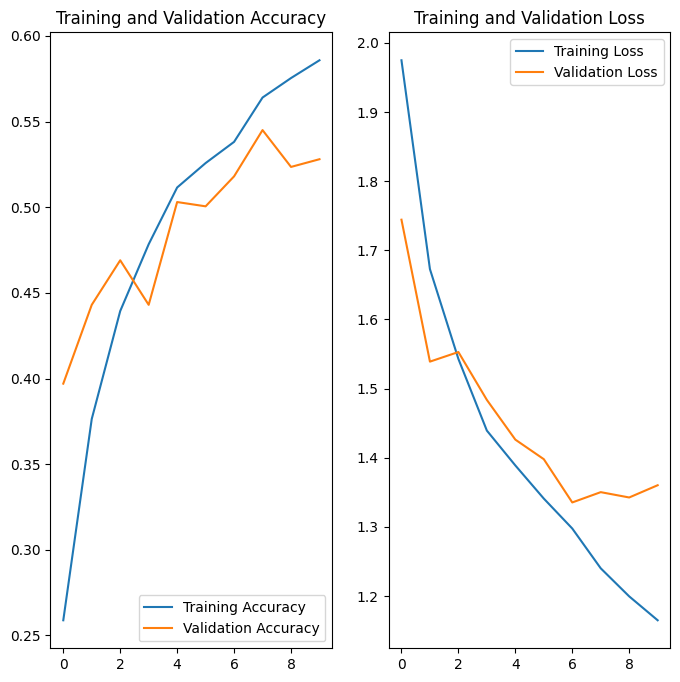

63/63 [==============================] - 40s 629ms/step
Classification Report
              precision    recall  f1-score   support

       blues       0.10      0.12      0.11       200
   classical       0.06      0.07      0.07       200
     country       0.11      0.18      0.14       200
       disco       0.04      0.01      0.02       200
      hiphop       0.07      0.04      0.06       200
        jazz       0.07      0.09      0.08       200
       metal       0.08      0.10      0.09       200
         pop       0.11      0.07      0.09       200
      reggae       0.12      0.15      0.13       200
        rock       0.07      0.02      0.03       200

    accuracy                           0.09      2000
   macro avg       0.08      0.09      0.08      2000
weighted avg       0.08      0.09      0.08      2000



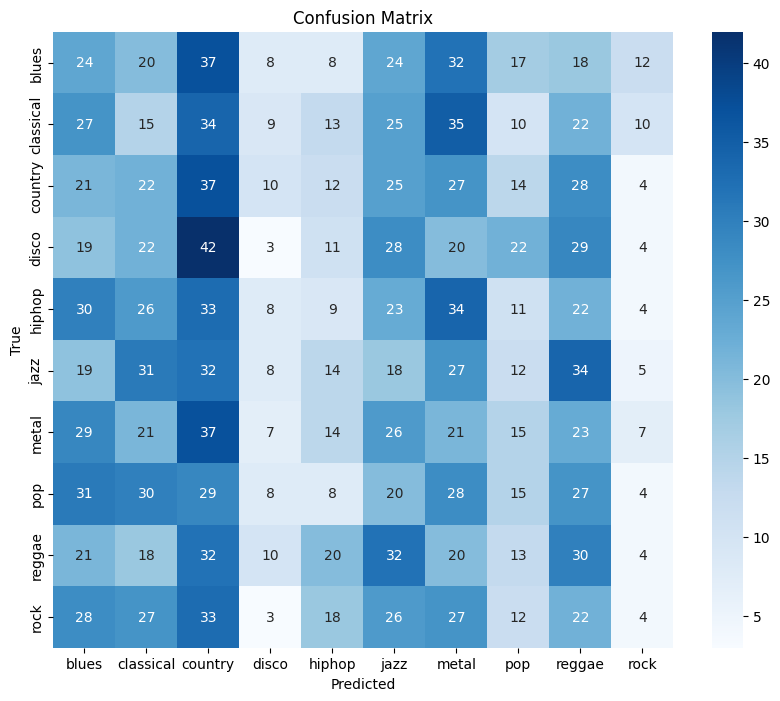

In [ ]:
# Plot training history
plot_history(history)

# Print metrics report
print_metrics_report(model, validation_generator, class_names)

## Git Commit

In [ ]:
!git status

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Music-Genre-Classification.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:

!git config --global user.name "AyaSafan"
!git config --global user.email "ayasafan16@gmail.com"

!git add .
!git commit -m "build CNN"
!git push origin master


[master aaf7963] build CNN
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 41.24 KiB | 1.21 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/AyaSafan/Music-Genre-Classification.git
   58489b9..aaf7963  master -> master
